In [20]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from category_encoders import OrdinalEncoder
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay, classification_report)
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

In [2]:
def wrangle(file):
    df = pd.read_csv(file)

    df.drop(columns = "Id", inplace = True)
    return df

In [3]:
df = wrangle("iris.csv")
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
print(df.shape)
print(df.info())

(150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


In [5]:
df.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [6]:
df["Species"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Text(0.5, 1.0, 'Class Balance')

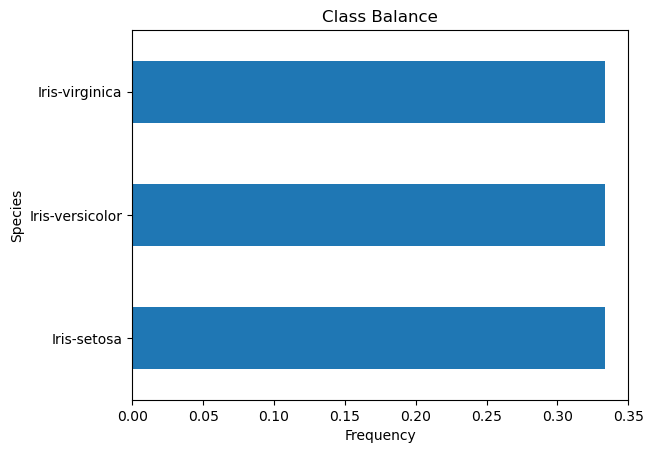

In [7]:
df["Species"].value_counts(normalize = True).plot(kind = "barh")
plt.xlabel("Frequency")
plt.ylabel("Species")
plt.title("Class Balance")

In [8]:
corr = df.select_dtypes(include = "number").corr()
corr

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


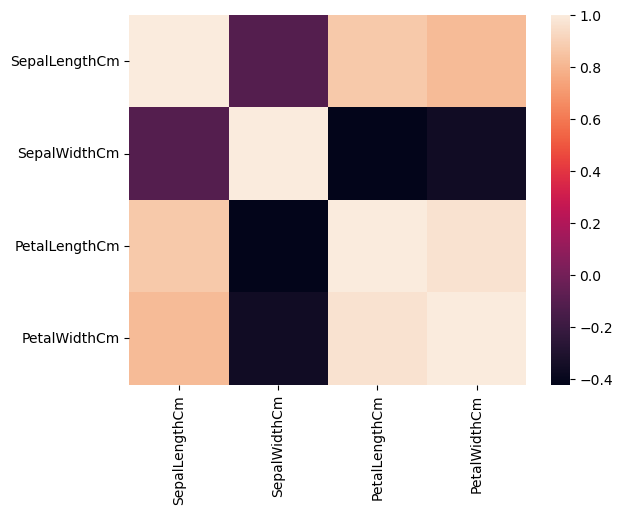

In [9]:
sns.heatmap(corr);

#### SPLIT

In [10]:
target = "Species"
X = df.drop(columns = "Species")
y = df[target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (120, 4)
y_train shape: (120,)
X_test shape: (30, 4)
y_test shape: (30,)


## BUILD MODEL

#### BASELINE

In [12]:
y_train.value_counts(normalize = True).max()

0.3416666666666667

#### ITERATE

In [13]:
# Initialize the model
model = DecisionTreeClassifier(random_state=42, max_depth = 3, min_samples_leaf = 1, min_samples_split =  2)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


## after getting the best params from the GridSearchCV then you can re-Iterate

In [14]:
# EVALUATE
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.96
Test Accuracy: 1.0


this shows that the data OVERFIT

In [15]:
#We will use hyperparameters
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
params = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid = params, cv=3, scoring="accuracy", n_jobs = -1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 1.0


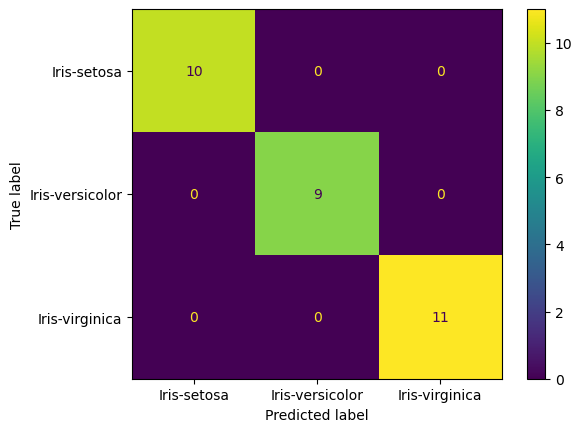

In [16]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [17]:
# Evaluate the model
print(classification_report(y_test, model.predict(X_test)))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



## COMMUNICATE RESULTS

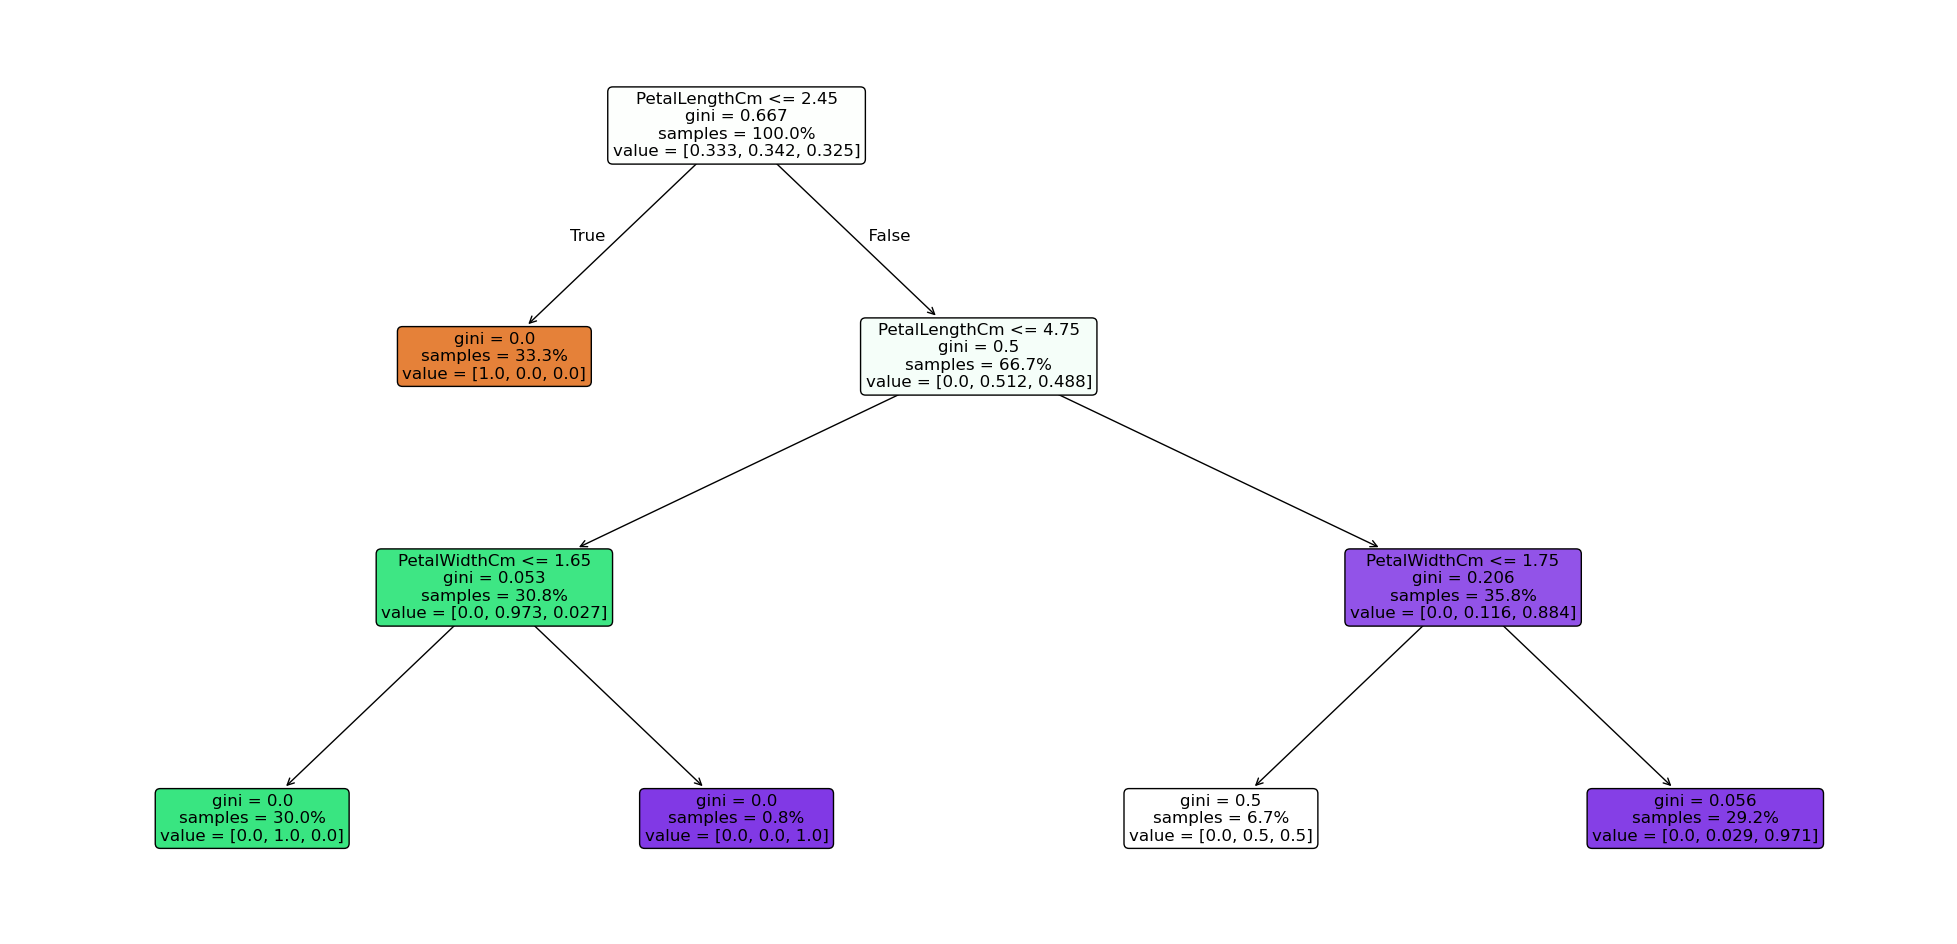

In [18]:
# Plot the decision tree
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    model,
    feature_names=X_train.columns.to_list(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

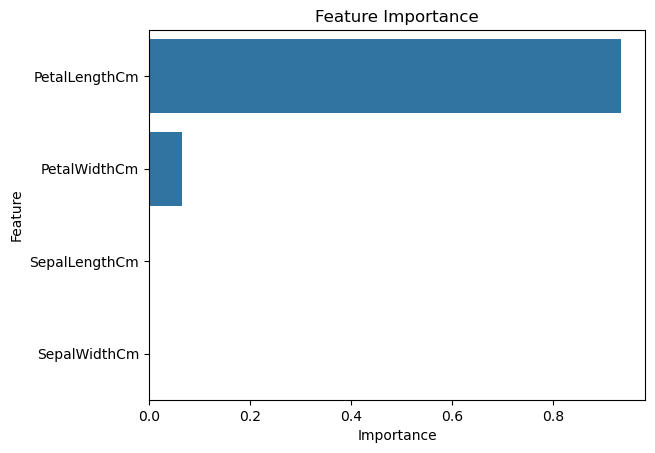

In [19]:
#feature Importances
# Get feature importances
importances = best_model.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot the feature importances
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()

In this project, we successfully built a Decision Tree Classifier to predict the species of iris flowers based on their sepal and petal measurements. Here are the key takeaways:

#### Exploratory Data Analysis (EDA):

We visualized the dataset and observed clear distinctions between the three species, particularly in petal measurements.

The species Iris-setosa was easily separable, while Iris-versicolor and Iris-virginica showed some overlap.

#### Model Performance:

The Decision Tree Classifier achieved an accuracy of 96.67% on the test set, demonstrating its ability to generalize well to unseen data.

The classification report and confusion matrix confirmed that the model performed well across all three species.

#### Feature Importance:

The most prominent feature for classification was Petal Length (cm), followed by Petal Width (cm). This aligns with our EDA, where petal measurements showed the strongest correlation with species.

Sepal measurements, while useful, played a lesser role in the model’s decision-making process.

#### Interpretability:

One of the key advantages of decision trees is their interpretability. By visualizing the tree, we gained insights into how the model makes predictions based on feature thresholds.

#### Future Work:

Experiment with other classification algorithms (e.g., Random Forest, Gradient Boosting) to compare performance.

The Iris dataset is a classic example of how simple yet powerful machine learning algorithms like decision trees can solve real-world classification problems. By understanding the relationships between features and target variables, we can build models that not only perform well but also provide valuable insights into the data.

Thank you for exploring this project! Feel free to reach out with any questions or suggestions.